In [3]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import shelve

BACKTEST = 3 # years, recommend at least 1~3 years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.4
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
SEED = 2600000 # principal
CUTOFF = 7
lambda_penalty = 0.5 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [4]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

tickers = []

with shelve.open("../cache/ticker_cache") as cache:
    for ticker, (name, score) in cache.items():
        if score >= CUTOFF:
            tickers.append(ticker)


In [5]:
#stock = yf.Ticker("379800.KS") #개별주 시장가 확인
stock = yf.Ticker("KRW=X") #환율
price = stock.info['regularMarketPrice']
print(stock.info['currency'] + " " + str(price))

KRW 1366.89


In [6]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                383220.KS     011200.KS     012330.KS     175330.KS  \
Date                                                                  
2022-06-20  128249.148438  22311.300781  187984.93750   6136.121582   
2022-06-21  132477.125000  23062.373047  189398.37500   6269.345703   
2022-06-22  126370.023438  22443.841797  186571.53125   5995.061035   
2022-06-23  124960.695312  21206.779297  185158.09375   5752.124023   
2022-06-24  129188.695312  21295.142578  186100.37500   6018.570801   
...                   ...           ...           ...           ...   
2025-06-11   77800.000000  22500.000000  288500.00000  19390.000000   
2025-06-12   77600.000000  23000.000000  284500.00000  20900.000000   
2025-06-13   74600.000000  24200.000000  282000.00000  20000.000000   
2025-06-16   75900.000000  24300.000000  285500.00000  21000.000000   
2025-06-17   76100.000000  23000.000000  286000.00000  21900.000000   

               051600.KS     002790.KS      005830.KS      103140.KS  \
Date

In [7]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [8]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           383220.KS  011200.KS  012330.KS  175330.KS  051600.KS  002790.KS  \
383220.KS   0.122164  -0.000771   0.021579   0.036966   0.032828   0.042036   
011200.KS  -0.000771   0.195199   0.045277   0.036007   0.010474   0.031011   
012330.KS   0.021579   0.045277   0.150376   0.042875   0.028608   0.039242   
175330.KS   0.036966   0.036007   0.042875   0.143689   0.051067   0.049411   
051600.KS   0.032828   0.010474   0.028608   0.051067   0.178196   0.028758   
002790.KS   0.042036   0.031011   0.039242   0.049411   0.028758   0.102121   
005830.KS   0.034316   0.030056   0.054151   0.069549   0.044383   0.028460   
103140.KS   0.011942   0.070323   0.039438   0.010338   0.048321   0.034318   
402340.KS   0.049731   0.051871   0.087918   0.118827   0.074790   0.075298   
064350.KS   0.012713   0.054897   0.003606   0.034105   0.060448   0.032119   
064400.KS   0.021474   0.019827   0.027225   0.056474   0.072049   0.025411   
241560.KS   0.049692   0.021107   0.023984   0.04519

In [9]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [10]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [11]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [12]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '34e4735c415e19669e7094dbd83af34f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_16280/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [13]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
# constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
#               {'type': 'eq', 'fun': lambda weights: weights[tickers.index('379800.KS')] - 0.75}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [14]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [15]:
optimal_weights = optimized_results.x #.x gets the results

In [16]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [17]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [18]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 100
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [19]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
----------------------------------------------------------------------------------------------------
Returns                                                                                                                            1.367755
Volatility                                                                                                                         0.266059
Sharpe Ratio                                                                                                                       5.140794
Portfolio Weights    [0.0386, 0.1011, 0.0171, 0.0045, 0.0162, 0.0376, 0.014, 0.1394, 0.0209, 0.1532, 0.1478, 0.0044, 0.1125, 0.1198, 0.073]
Name: 427, dtype: object
----------------------------------------------------------------------------------------------------

MIN VOLATILITY:
----------------------------------------------------------------------------------------------------
Returns                                                                     

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [20]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [23]:
optimal_weights = optimized_results_max_sharpe.x
threshold = 10e-4

# print(optimal_weights)
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights (최적화 가중치):")
print("원금: " + f"{SEED:,}"+ "원. 백테스팅 기간: " + F"{BACKTEST}" + "년")
for ticker, weight in zip(tickers, optimal_weights):
    if weight >= threshold:
        num = round(SEED * weight)
        with shelve.open("../cache/ticker_cache") as cache:
            print(f"{ticker}({cache[ticker]}): {weight:.4f}" + ", 투자금액: " +  str(f"{num:,}") + "원")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights (최적화 가중치):
원금: 2,600,000원. 백테스팅 기간: 3년
383220.KS(('F&F Co., Ltd', 7.0)): 0.0340, 투자금액: 88,441원
011200.KS(('HMM Co.,Ltd', 9.0)): 0.0251, 투자금액: 65,362원
002790.KS(('AMOREPACIFIC Holdings Corp.', 7.3)): 0.0389, 투자금액: 101,269원
103140.KS(('Poongsan Corporation', 9.0)): 0.0769, 투자금액: 199,845원
402340.KS(('SK Square Co., Ltd.', 7.0)): 0.0205, 투자금액: 53,407원
064350.KS(('Hyundai Rotem Company', 7.0)): 0.2263, 투자금액: 588,287원
064400.KS(('LG CNS', 7.15)): 0.1102, 투자금액: 286,518원
214450.KQ(('PharmaResearch Co., Ltd.', 7.0)): 0.1109, 투자금액: 288,289원
012750.KS(('S-1 Corporation', 7.0)): 0.1941, 투자금액: 504,763원
030000.KS(('Cheil Worldwide Inc.', 7.0)): 0.1630, 투자금액: 423,818원
Expected Annual Return: 1.4461
Expected Volatility: 0.2684
Sharpe Ratio: 5.2222


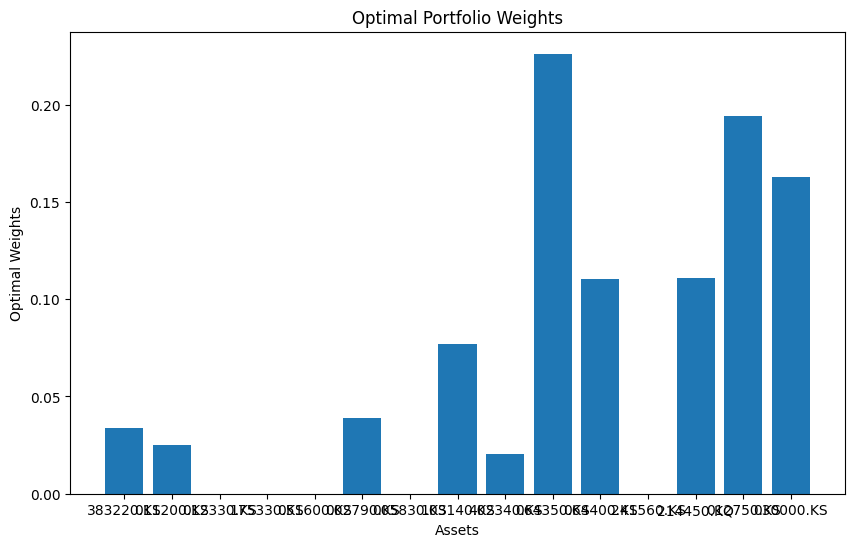

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()